In [3]:
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib import animation, rc
import mpl_toolkits.mplot3d.axes3d as axes3d
mpl.rc('ytick', direction='in', right=True)
mpl.rc('xtick', direction='in', top=True)
plt.rc('axes', labelsize=20) # axes labels
plt.rc('axes', titlesize=22) # axes title
plt.rc('legend', fontsize=20) # legend
plt.rc('figure', titlesize=26) # title
plt.rc('font', size=20) # default
mpl.rc('xtick.minor', visible=True)
mpl.rc('ytick.minor', visible=True)
rc('animation', html = 'jshtml')
import scipy.interpolate as interp
from IPython.display import HTML
import scipy.integrate as integ
#from playsound import playsound
import numpy.random as random
import scipy.optimize as opt
from numba import jit,prange
import scipy.special as sf
import scipy.linalg as la
import scipy.misc as ms
import numpy as np
%matplotlib inline
#import xlrd
import time
import math
import sys

# Introducing: The Coffee Stain Problem

Coffee is the second most-traded commodity in the world, second only to oil. As possibly the most consumed invented beverage, coffee spills happen daily, if not hourly. While not an obvious problem by itself, coffee spills usually cause minimal issues in a vaccuum, but accidents can be disatrous enough to make the news.

https://en.wikipedia.org/wiki/Liebeck_v._McDonald's_Restaurants

https://www.bbc.com/news/world-europe-49672351

https://www.flightglobal.com/safety/injurious-coffee-spill-counts-as-accident-advocate-general/134542.article

https://www.bloomberg.com/news/articles/2019-12-19/spilled-drinks-may-land-airlines-in-hot-water-after-eu-ruling

https://flightsafety.org/coffee-spill-leads-to-smoke-then-a-diversion/

We will be referencing the paper "Contact line deposits in an evaporating drop" quite often: https://journals.aps.org/pre/pdf/10.1103/PhysRevE.62.756

This paper is also linked in the repository.

However, this project will not be directly covering large coffee spills. The spills we analyze will be small and on smooth surfaces. This smooth surface decision is quite fair, as most coffee spills happen on tables and on floors – which are presumably the most frequent and are approximately smooth. However, we are deliberately analyzing small coffee spills. This is for a few reasons.

One being, if we turn back time and remove every non-newsworthy coffee spill in history, humanity may have advanced non-trivially farther than we have so far. As author Rouslan Krechetnikov, a mechanical engineer at the University of California, Santa Barbara says, "I cannot say for sure if coffee spilling has been detrimental to scientific research to any significant extent, "but it can certainly be disruptive for a train of thought." https://www.sciencemag.org/news/2012/05/physics-spilled-coffee.

Secondly, the macro cannot be understood without the micro. For example, theory in nucleosynthesis gives humanity insight to the origins of the universe. Thus, solving the physics of small coffee spills may pave the way for solving the dynamics of general liquid spills.

Of course, a major reason for this is that computing motion for liquid in three spacial dimensions requires major computing power. Computations of larger spills will be left to physicists with more powerful computers than our own.

# Delving into the MATH

The Coffee Stain problem can be thought of as a generalization of the quantity conservation equation.  This equation parallels charge conservation in E&M, but here there is a source sink that the mass can disapear inside. To explain the equation "the rate of change of the amount of fluid in an infinitesimal annular element at a radial distance $r$ from the center of the drop is equal to the net flux of liquid into the column minus the amount of mass evaporated from the surface of that element".
Thus, the paper describes:
$$\rho \frac{\partial h}{\partial t}=-\rho\nabla\cdot(hv)-J_s(r,t)\sqrt{1+\left(\frac{\partial h}{\partial r}\right)^2}
$$
where the divergence is simplified by considering motion only in the (cylindrical) r direction.  The flow velocity should not flow in the z direction since that is unphysical, and it should also not flow in the $\phi$ direction since that would be a vortex. $h$ is a function of both r and t while $v$ is a function of both r and t as well. Unlike the analytic solution, we must provide constants to aid our numerical program. We will use coffee with a density of about 1.00g/ml (the density of coffee liquid is practically the density of water https://www.aqua-calc.com/calculate/food-volume-to-weight/substance/beverages-coma-and-blank-coffee-coma-and-blank-brewed-coma-and-blank-prepared-blank-with-blank-tap-blank-water).

This problem is solved exactly for the circular case as documented in the aforementioned paper.  We feel it is not necessary to write down all of the analytic solution steps since they are already in said paper. These steps will appear after our analysis of the general case. 

## General Elliptical Solution

To solve the problem more generally, the question could be asked what happens when the droplet is placed on the surface in a way that it is no longer circular.  In other words, what happens when the drop is elliptical?

We originally attempted to express the equation in elliptical coordinates to try and get the differential area element to rederive the results, but then we found out that the square root term is actually just the surface area at a height of h.  Knowing that, we can easily generalize this formula to elliptical curves by enforcing the use of x and y coordinates instead of the radially symmetric r.  The result is:
$$\rho \frac{\partial h}{\partial t}=-\rho \nabla\cdot(hv)-J_s(x,y,t)\sqrt{1+\left(\frac{\partial h}{\partial x}\right)^2+\left(\frac{\partial h}{\partial y}\right)^2}
$$

where v and h now becomes functions of x and y instead of just r.  This equation reduces to
$$\rho \frac{\partial h}{\partial t}=-\rho \left(\frac{\partial hv_x}{\partial x}+\frac{\partial hv_y}{\partial y}\right)-J_s(x,y,t)\sqrt{1+\left(\frac{\partial h}{\partial x}\right)^2+\left(\frac{\partial h}{\partial y}\right)^2}
$$

which further simplifies using the chain rule to
$$\rho \frac{\partial h}{\partial t}=-\rho \left(\frac{\partial h}{\partial x}v_x+\frac{\partial h}{\partial y}v_y+\left[\frac{\partial v_x}{\partial x}+\frac{\partial v_y}{\partial y}\right]h\right)-J_s(x,y,t)\sqrt{1+\left(\frac{\partial h}{\partial x}\right)^2+\left(\frac{\partial h}{\partial y}\right)^2}
$$

The first step to reducing this is to come up with a value for the function h(x,y,t).  In the paper, they assumed a functional form of a spherical cap which takes a sphere and assigns the max height of the cap to be on the sphere just at a vertical displacement.  We will assume the same logic, except generalize the system to an elliptical shape intersecting the plane.  The paper's reasoning for the spherical shape was that the external pressure was uniform and equal on all sides to force the liquid to take the shape of a sphere.  We will have to try and understand the implications of having a elliptical shape.  By observing the Navier-Stokes equation, we assume the gradient of the pressure must no longer be 0 to force the liquid to stay in an elliptical shape.  This means that the velocity of the fluid must be flowing faster in the direction where the ellipse is larger and the that fluid must have a lower velocity at the shorter end of the ellipse.  This non-symmetrical property is of great interest. 
Regardless, we must first assume the most general ellipsoidal shape:
$$\left(\frac{x}{a}\right)^2+\left(\frac{y}{b}\right)^2+\left(\frac{z}{c}\right)^2=1
$$
where when $a=b=c$ the equation reduces to that of a sphere in cartesian coordinates.  Because we will be assuming no fluid flow in a circle through the center of the medium, we can expect there to still be a symmetry for our ellipsoidal system.  Instead of just looking at a radial direction in the convienent cylindrical coordinates for the simple spherical case, we are interested in just the positive xy quadrant since all others should just reflect and match the single quadrant.  Here we will assume the maximum height of the ellipsoid is some $h(0,0,t)$ that is less than c.  We will assume $h(0,0,0)=0.1$cm since that is roughly a good starting value for the height of a coffee spill. We also will then make the assumption that we have a very skinny ellipsoid in the z direction. This means that the equation for a paraboloid can describe it. Thus we assume a shape of h:
$$h(x,y,t)=h(0,0,t)\left[1-\left(\frac{x}{x_m}\right)^2-\left(\frac{y}{y_m}\right)^2\right]$$
where we assume $x_m$ is the measured major axis of the ellipse on the ground surface and $y_m$ is the measured minor axis of the ellipse on the ground surface.  For our problem, we would like to solve for $x_m=2$cm and $y_m=1$cm for roughly a small drop that should solve relatively fast (we hope).  We can implement for other larger drop sizes easily assuming our algorithms converge relatively quickly for bigger sizes. This then simplifies the profile of the drop down to being expressed only in terms of $a$, $b$, and $h(0,0,t)$. Precisely our goal.

Next we must find $J_s(x,y,t)$.  We will assume that $J_s$ is depends on the diffusive relaxation of the saturated layer above the drop. From the paper, if we assume we rapidly reach steady state, we can use
$$\nabla^2u=D\frac{\partial u}{\partial t}\approx0
$$
where $u$ is the mass of vapor per volume of air and $D$ is the diffusion constant for water vapor in air. In our case, $\vec{\nabla} u=-\vec{J}$ and we are assuming $D$ is small.  Therefore, after we solve for $u$ we can take the gradient to get $\vec{J}$.  The reason why we are solving for $u$ instead of directly solving for $J_s$ is that we have Robin boundary conditions that require the use of $u$ directly in solving our problem. 
In our case we want $J_s$ which is $\vec{J}\cdot\hat{n}$ where $\hat{n}$ is the unit normal to the surface.  This can only be evaluated on the surface of the droplet so $J_s$ can not be a vector and is a function of $x,y,$ and $t$. 

(1) The boundary conditions are that we require $u=u_s$ at the surface of the drop since the air is saturated with vapor.  
(2) Also we require that there is no current normal to the surface the droplet sits on since no evaporation can occur through the ground, which means $J\cdot\hat{n}=-D\frac{\partial u}{\partial n} $.  
(3) Finally, u must go to 0, the ambient amount of liquid in the air far from the evaporation location.  Thus we have 2 Dirichlet boundary condition, and 1 Neumann boundary condition.

We have figured that boundary condition 3 fixes $u_x,u_y,$ and $u_z$ since in all directions it must go to 0.  Boundary condition 2 fixes $J_z$ since it must go to 0 at the plane surface.  Finally, boundary condition 1 must fix $J_x$ and $J_y$.  We have found out that Boundary condition 1 will trace the shape of h in the z direction, so it will specify 2 more conditions to make our solution unique.

## Finding h(x,y,t)
The first step to getting $h(x,y,t)$ is to finally get $J_s$, as we mentioned earlier, we must calculate $\vec{J}\cdot\hat{n}$ which is written down fully as $\vec{\nabla} u \cdot \hat{n}$ evaluated only on the surface of the droplet. In phase 1 we thought that finding $h(x,y,t)$ was going to be a trivial operation. However, after more thought on the matter, we developed this entire section describing how to actually derive $h(x,y,t)$.  It turns out to be the opposite of trivial like we had initially hoped.

The normal vector itself is a function of $h(x,y,t)$ which is the surface it resides on.  As you might recall $\vec{n}=\{\frac{\partial h}{\partial x},\frac{\partial h}{\partial y},-1\}$. It is normalized by dividing by $\sqrt{1+\left(\frac{\partial h}{\partial x}\right)^2+\left(\frac{\partial h}{\partial y}\right)^2}$.  As a result we find that 
$$J_s\sqrt{1+\left(\frac{\partial h}{\partial x}\right)^2+\left(\frac{\partial h}{\partial y}\right)^2}=\vec{\nabla}u\cdot\hat{n}$$ which may look awfully similar to the third term in the original equation we are solving.

Now here is a bit of sleight of hand.  Originally when we were deriving the original equation we looked at an infitesimal area element and considered the net flux, evaporation, and mass conservation.  However looking at the entire system at once means there is no net flux anymore inside of the drop since holistically we are examining the entire system. The result is a double integral over the original equation for the area of the droplet will send the net flux contribution to 0.  Thus this describes that the change of volume of the drop must be equal to the total evaporation. The result is this equation:
$$\frac{dM}{dt}=\rho\frac{\partial}{\partial t}\int\int_A dA\space h(x,y,t)=\int\int_A dA\space J_s\sqrt{1+\left(\frac{\partial h}{\partial x}\right)^2+\left(\frac{\partial h}{\partial y}\right)^2}$$
which we extrapolated from equation 7 in the paper.  We transformed from cylindrical coordinates into cartesian coordinates.  This is a very loaded equation that is difficult to analyze numerically. The reason is that $h(x,y,t)$ is unknown so traditional integral methods are not useful to evaluate this.  If we take derivatives we are forced to go back to the original equation which is not useful. Thus, we must actually evaluate these integrals as far as we can analytically and get them into a form that we can actually numerically handle.

Lets start with the left hand side of the equation above.  This is a terrible integral to evaluate the way we have $h(x,y,t)$ written down earlier. Instead it is better to think back to how $h(x,y,t)$ was derived earlier. Effectively it is the surface of an ellipsoidal cap. We can derive a formula to calculate the volume under an ellipsoidal cap. Then we can substitute back our parameters and make it useful in our problem.

The original ellipsoidal shape was described by the equation. This approximation assumes that the volume under our ellipsoid is the same as the volume under our paraboloid. 
$$\left(\frac{x}{a}\right)^2+\left(\frac{y}{b}\right)^2+\left(\frac{z}{c}\right)^2=1$$
where $a,b,$ and $c$ are the axes of the ellipsoid.  The first step is finding the curvature along the x and y axes of the 3D shape. By setting $y=0$ we find that 
$$\left(\frac{x}{a}\right)^2+\left(\frac{z}{c}\right)^2=1$$
which can be solved to find 
$$x=\frac{a}{c}\sqrt{c^2-z^2}.$$ Similiarly we can do the same by setting $x=0$ and we find that $$y=\frac{b}{c}\sqrt{c^2-z^2}.$$

Now we have $x$ and $y$ implicitly defined in terms of z. Next we know that the area of an ellipse is given by 
$$A=\pi xy$$ where x and y are the axes of the ellipse.  Thus, each cross section of our ellipse is given by this formula. Plugging in our earlier findings gives us
$$A=\pi \frac{ab}{c^2}(c^2-z^2)=\pi ab\left(1-\left(\frac{z}{c}\right)^2\right).$$
The next logical step to finding the volume in our cap is to integrate all of the values of $z$:
$$V=\int^c_{c-h(0,0,t)}dz \space A$$
where $h(0,0,t)$ shows up inside of the integral and demonstrates why this could not be done numerically.  We can substitute in our findings for A and evaluate.
$$V=\int^c_{c-h(0,0,t)}dz \space \pi ab\left(1-\left(\frac{z}{c}\right)^2\right)=\pi ab \space h(0,0,t)-\frac{\pi ab}{3c^2}\left(c^3-(c-h(0,0,t))^3\right)$$
where we can manipulate the algebra on the right side to get
$$V=\pi ab h(0,0,t)-\frac{\pi ab}{3 c^2}\left(h(0,0,t)^3+3(c^2h(0,0,t)-h(0,0,t)^2 c)\right)$$
which has another cancelation.  With a final substitution we find
$$V=(3c-h(0,0,t))\frac{\pi ab \space h(0,0,t)}{3c^2}$$
where we now have the volume of the elliptical cap defined in terms of the function we have yet to solve, $h(0,0,t)$.

We can check this result by plugging in $h(0,0,t)=2c$ which should be the integral over the entire volume of the ellipse.  Indeed this matches the desired result of $V=\frac{4\pi abc}{3}$.

Now we should substitute back in our values for $x_m$ and $y_m$ since we do not ever know what $a,b,$ and $c$ are since they change in time as the liquid evaporates. We find that
$$V=(3c-h(0,0,t))\frac{\pi x_m y_m \space h(0,0,t)^2}{2h(0,0,t)c-h(0,0,t)^2}=\left(\frac{3c-h(0,0,t)}{2c-h(0,0,t)}\right)\pi x_m y_m \space h(0,0,t).$$
A final simplification puts $V$ into a much more usable form
$$V(t)=\pi x_m y_m \space h(0,0,t)\left(\frac{c}{2c-h(0,0,t)}+1\right).$$

If you might recall earlier we defined $c$ in terms of a large fraction that depended on $x$ and $y$. The reason why is that $x$ and $y$ were related to the surface of the ellipsoid. Thus c is effectively just a function of $t$ and everything else in this expression is constant besides $h(0,0,t)$ which we want to solve for.  Now that we have $V$ we can plug this into the expression above to continue simplifying
$$\rho\frac{\partial}{\partial t}V(t)=\int\int_A dA\space J_s\sqrt{1+\left(\frac{\partial h}{\partial x}\right)^2+\left(\frac{\partial h}{\partial y}\right)^2}$$

We would now like to calculate the time derivative of $V(t)$.  By the chain rule we find
$$\frac{d V}{dt}=\frac{d}{dt}\left[\frac{c}{2c-h(0,0,t)}\right]\pi x_m y_m \space h(0,0,t)+\pi x_m y_m \space \frac{dh(0,0,t)}{dt}\left(\frac{c}{2c-h(0,0,t)}+1\right)$$ where we can finally use the substitution for c we made earlier. Since $c\equiv\gamma \space h(0,0,t)$ the left derivative vanishes and goes to 0 leaving
$$\frac{d V}{dt}=2\pi x_m y_m \space \frac{dh(0,0,t)}{dt}.$$

We can plug this into the equation we are solving and we finally have the left hand side simplified to a useful point
$$\frac{dM}{dt}=2\rho\pi x_m y_m \space \frac{dh(0,0,t)}{dt}=\int\int_A dA\space J_s\sqrt{1+\left(\frac{\partial h}{\partial x}\right)^2+\left(\frac{\partial h}{\partial y}\right)^2}$$
where the left hand side is all constants besides for the time derivative part.

Now we need to tackle the right hand side of the previous equation. We have an equation for $h(0,0,t)$ which is not a nice formula to solve for the partial derivatives with respect to $x$ and $y$. Mathematica can do it, and it finds an expression that fills a computer screen and a half.  Also, might you remember that hidden inside of $J_s$ is a dependence on $h(x,y,t)$ which is the unknown function we must solve. Thus, we substitute for this expression to find
$$\frac{dM}{dt}=\int\int_A dA\space \vec{\nabla}u\cdot\hat{n}$$
where we can begin to invoke some symmetries. We know that the shape of the ellipsoidal drop means that we only need to solve for the positive x,y quadrant of $J(x,y,z,t)$ since all the rest are reflected versions of $J(x,y,z,t)$.  Thus we can define the new area of integration $\Gamma$ to be just the positive x,y quadrant, and we know that $\Gamma$ encloses $1/4$ of the area so
$$\frac{dM}{dt}=4\int\int_{\Gamma} dA\space \vec{\nabla}u\cdot\hat{n}$$
we can write the dot product out to explicitly show the terms that are causing issues
$$\frac{dM}{dt}=4\int\int_{\Gamma} dA\space \left[\frac{\partial u}{\partial x}\frac{\partial h}{\partial x}+\frac{\partial u}{\partial y}\frac{\partial h}{\partial y}-\frac{\partial u}{\partial z}\right].$$
Once again the spatial derivatives of $h(x,y,t)$ attempts to show up again.  This time we can actually take steps to try and remove them. The first line of attack is applying integration by parts to each individual integral. For the time being we will only focus on the integral in the x direction
$$I=\int\int_{\Gamma} dA\space\frac{\partial u}{\partial x}\frac{\partial h}{\partial x}.$$
By defining $w\equiv\frac{\partial u}{\partial x}$ and $dv\equiv\frac{\partial h}{\partial x}$ we get the result $dw=\frac{\partial^2 u}{\partial x^2}dx$ and $v=h$. Here we assumed integration in the x direction takes priority first before integration in the y direction.  Thus,
$$I=\int dy \space \left[\frac{\partial u}{\partial x}h(x,y,t)-\int dx\space\frac{\partial^2 u}{\partial x^2}\space h(x,y,t)\right]$$
where you might have thought we went through with haste and missed evaluating the bounds of our integral. This is a bit unusual but for the time being in the x direction it will seem quite normal.  The area defined by $\Gamma$ is the positive xy quadrant.  It is the entire area inside the ellipsoidal surface intersecting the plane.  We can take the traditional ellipsoidal shape formula and substitute $z=h(x,y,t)+c-h(0,0,t)$.  Thus we get the equation
$$h(x,y,t)=h(0,0,t)\left[1-\left(\frac{x}{x_m}\right)^2-\left(\frac{y}{y_m}\right)^2\right]$$

We can then start to solve for positive x, giving us
$$x=x_m\sqrt{1-\left(\frac{y}{y_m}\right)^2}.$$
Thus, our first integral along $dx$ is evaluated from $0$ to this curve. Also, our second integral will then be evaluated along $dy$ from $0$ to $y_m$.  The nice part about this is that the bounded term extracted from integration by parts gets evaluated on this curve. One of the terms inside is $h(x,y,t)$.  From the way our problem is setup, $h(x,y,t)$ must go to 0 along the boundaries.  Therefore there is no contribution from $h(x,y,t)$ when evaluated on the upper boundary. Thus we can conclude that
$$I=\int_0^{y_m} dy \space \left[-\left(\frac{\partial u}{\partial x}\right)_{x=0}h(0,y,t)-\int_0^{x_m\sqrt{1-\left(\frac{y}{y_m}\right)^2}} dx\space\frac{\partial^2 u}{\partial x^2}\space h(x,y,t)\right]$$
where we have simplified the expression.  Let us just examine the left most integral here for the time being
$$I'=\int_0^{y_m} dy \space \left(\frac{\partial u}{\partial x}\right)_{x=0}h(0,y,t).$$
If we evaluate for $h(0,y,t)$ we find that
$$h(0,y,t)=h(0,0,t)\left[1-\left(\frac{y}{y_m}\right)^2\right]$$
where we notice the time dependence of the integral can be entirely removed in the form of $h(0,0,t)$ if we substitute this expression. Thus we find 
$$I'=h(0,0,t)\int_0^{y_m} dy \space \left(\frac{\partial u}{\partial x}\right)_{x=0}\left[1-\left(\frac{y}{y_m}\right)^2\right]$$
where we can evaluate the remaining integral numerically since it now has only functions we can calculate numbers for.  Thus we can substitute back into $I$ to find
$$I=-h(0,0,t)\int_0^{y_m} dy \space \left(\frac{\partial u}{\partial x}\right)_{x=0}\left[1-\left(\frac{y}{y_m}\right)^2\right]-\int\int_{\Gamma} dA\space\frac{\partial^2 u}{\partial x^2}\space h(x,y,t)$$ where we have taken the right hand side and returned it back to an integral over $\Gamma$.

This concludes our evaluation of $I$ and we return back to the expression we pulled $I$ from. We will not go through the exact same step again, but the $\frac{\partial u}{\partial y}\frac{\partial h}{\partial y}$ term in the integral can follow the exact same steps in $y$ instead of $x$ and $y_m$ instead of $x_m$. This is where our bounds on our integral become a bit strange. Here the $dy$ integral is evaluated first and the $dx$ integral second. This can be done since the boundary curve is invertible and takes a similar form when integrating $y$ first. The result is 
$$\frac{dM}{dt}=-4h(0,0,t)\int_0^{y_m} dy \space \left(\frac{\partial u}{\partial x}\right)_{x=0}\left[1-\left(\frac{y}{y_m}\right)^2\right]-4h(0,0,t)\int_0^{x_m} dx \space \left(\frac{\partial u}{\partial y}\right)_{y=0}\left[1-\left(\frac{x}{x_m}\right)^2\right]-4\int\int_{\Gamma} dA\space\left[\frac{\partial^2 u}{\partial x^2}+\frac{\partial^2 u}{\partial y^2}\right]\space h(x,y,t)-4\int\int_{\Gamma} dA\space \frac{\partial u}{\partial z}$$

Here we can once again substitute for $h(x,y,t)$ in the integral to get the result
$$\frac{dM}{dt}=-4h(0,0,t)\int_0^{y_m} dy \space \left(\frac{\partial u}{\partial x}\right)_{x=0}\left[1-\left(\frac{y}{y_m}\right)^2\right]-4h(0,0,t)\int_0^{x_m} dx \space \left(\frac{\partial u}{\partial y}\right)_{y=0}\left[1-\left(\frac{x}{x_m}\right)^2\right]-4h(0,0,t)\int\int_{\Gamma} dA\space\left[\frac{\partial^2 u}{\partial x^2}+\frac{\partial^2 u}{\partial y^2}\right]\space \left[1-\left[\left(\frac{x}{x_m}\right)^2+\left(\frac{y}{y_m}\right)^2\right]\right]-4\int\int_{\Gamma} dA\space \frac{\partial u}{\partial z}.$$
We can simplify further noting our previous expression regarding $\nabla^2u=0$ as this is the equality
$$\left(\frac{\partial^2 u}{\partial x^2}\right)+\left(\frac{\partial^2 u}{\partial y^2}\right)+\left(\frac{\partial^2 u}{\partial z^2}\right)=0.$$
In the integral expression we can substitute
$$\left(\frac{\partial^2 u}{\partial x^2}\right)+\left(\frac{\partial^2 u}{\partial y^2}\right)=-\left(\frac{\partial^2 u}{\partial z^2}\right)$$
where we find that
$$\frac{dM}{dt}=-4h(0,0,t)\int_0^{y_m} dy \space \left(\frac{\partial u}{\partial x}\right)_{x=0}\left[1-\left(\frac{y}{y_m}\right)^2\right]-4h(0,0,t)\int_0^{x_m} dx \space \left(\frac{\partial u}{\partial y}\right)_{y=0}\left[1-\left(\frac{x}{x_m}\right)^2\right]+4h(0,0,t)\int\int_{\Gamma} dA\space\frac{\partial^2 u}{\partial z^2}\space \left[1-\left[\left(\frac{x}{x_m}\right)^2+\left(\frac{y}{y_m}\right)^2\right]\right]-4\int\int_{\Gamma} dA\space \frac{\partial u}{\partial z}.$$
Remembering that
$$\frac{dM}{dt}=2\rho\pi x_m y_m \space \frac{dh(0,0,t)}{dt}$$  allows us to write the equation in a more simplified form. In theory we can actually evaluate all of these integrals.  However, when we do, we still do not have an expression for $h(0,0,t)$ which then describes an expression for $h(x,y,t)$. We still have to solve a simple differential equation to get back $h(0,0,t)$. Lets make some definitions to allow us to move forward without all the clunky variables. 

First,
$$\alpha\equiv2\rho \pi x_m y_m.$$
Second,
$$G(t)\equiv-4\int_0^{y_m} dy \space \left(\frac{\partial u}{\partial x}\right)_{x=0}\left[1-\left(\frac{y}{b}\right)^2\right]-4\int_0^{x_m} dx \space \left(\frac{\partial u}{\partial y}\right)_{y=0}\left[1-\left(\frac{x}{x_m}\right)^2\right]+4\int\int_{\Gamma} dA\space\frac{\partial^2 u}{\partial z^2}\space \left[1-\left[\left(\frac{x}{x_m}\right)^2+\left(\frac{y}{y_m}\right)^2\right]\right].$$
And finally,
$$F(t)\equiv4\int\int_{\Gamma} dA\space \frac{\partial u}{\partial z}.$$
This allows us to write the differential equation
$$\alpha \frac{dh(0,0,t)}{dt}=G(t)h(0,0,t)-F(t)$$
which has the solution
$$h(0,0,t)=\exp{\left(\int_0^t \frac{G(t')}{\alpha}dt'\right)}\left[t_{max}-\int^t_0 \frac{F(t'')\exp{\left(-\int_0^{t''}\frac{G(t')}{\alpha}dt'\right)}}{\alpha}dt''\right]$$
where $t_{max}$ is the maximum time for the solution you want to solve.
Thus, we have achieved the goal of solving for h(x,y,t)
$$h(x,y,t)=\left[1-\left[\left(\frac{x}{x_m}\right)^2+\left(\frac{y}{y_m}\right)^2\right]\right]\left[\exp{\left(\int_0^t \frac{G(t')}{2\rho \pi x_m y_m}dt'\right)}\left[t_{max}-\int^t_0 \frac{F(t'')\exp{\left(-\int_0^{t''}\frac{G(t')}{2\rho \pi x_m y_m }dt'\right)}}{2\rho \pi x_m y_m }dt''\right]\right]_{eval}$$
where almost everything in the expression must be evaluated on the surface of the droplet.

## Steps after getting h(x,y,t)

We can calculate $\frac{\partial h}{\partial x}$ by taking the numerical center differencing derivative to the h function as we found earlier.  We did find an exact solution in Mathematica, but it would be quite a grind to implement it.  The same process would occur for $\frac{\partial h}{\partial y}$.  With these derivatives, we can now plug into the equation of $J$ to solve for $J_s$ by a simple substitution at each time step.  Since $u$ will be constrained in the z direction, this directly corresponds to the $h(0,0,t)$ boundary term where we will look only at the $x=0$ and $y=0$ parts to determine $h(x,y,t)$ competely.  This gives us the function of $J_s$ at each time step, which then can be used to solve for $v$ in the original master equation.

The last step is to solve the earlier equation, as written above:
$$\rho \frac{\partial h}{\partial t}=-\rho \left(\frac{\partial h}{\partial x}v_x+\frac{\partial h}{\partial y}v_y+\left[\frac{\partial v_x}{\partial x}+\frac{\partial v_y}{\partial y}\right]h\right)-\frac{\partial u}{\partial x}\frac{\partial h}{\partial x}-\frac{\partial u}{\partial y}\frac{\partial h}{\partial y}+\frac{\partial u}{\partial z},
$$
by plugging in all of our solved values previously and using center differencing, or some other better differencing algorithm for $\frac{\partial v_x}{\partial v_y}$ and $\frac{\partial v_y}{\partial y}$, and solving for the values of $v$ from a linear system of equations. The issue is that there are infinitely many different solutions for $v$ and we want to figure out one of them. Without extra information we will have to solve for them coupled in some sort of way. We are unsure what a proper solution would be, and this requires more information than we have available. We already are implementing a complicated algorithm so we will treat $v$ as an extra value that we can calculate if we have time and if we can find more information on how the $v_x$ is related to the $v_y$.

We have contacted Dr. Mathur and his suggestion to fix our predicament it to assume that there is no curl in the velocity. This means that it only has a divergence. Physically this means that the fluid must always flow outwards and does not swirl and form any vortices. If we assume this then we get the relationship
$$\vec{v}=\vec{\nabla} f$$
where $f$ is some function. If we sub this expression into the above equation we get
$$\rho \frac{\partial h}{\partial t}=-\rho \nabla\cdot(h\vec{\nabla} f)-\frac{\partial u}{\partial x}\frac{\partial h}{\partial x}-\frac{\partial u}{\partial y}\frac{\partial h}{\partial y}+\frac{\partial u}{\partial z}.
$$
If we consider just the divergence term
$$-\rho \nabla\cdot(h\vec{\nabla} f)=-\rho(h(\vec{\nabla}\cdot\vec{\nabla}f)+\vec{\nabla}f\cdot\vec{\nabla}h)=-\rho(h\vec{\nabla}^2f+\vec{\nabla}f\cdot\vec{\nabla}h)= -\rho\left(h\frac{\partial^2 f}{\partial x^2}+h\frac{\partial^2 f}{\partial y^2}+\frac{\partial f}{\partial x}\frac{\partial h}{\partial x}+\frac{\partial f}{\partial y}\frac{\partial h}{\partial y}\right)$$
we can plug it in $$\rho \frac{\partial h}{\partial t}=-\rho\left(h\frac{\partial^2 f}{\partial x^2}+h\frac{\partial^2 f}{\partial y^2}+\frac{\partial f}{\partial x}\frac{\partial h}{\partial x}+\frac{\partial f}{\partial y}\frac{\partial h}{\partial y}\right)-\frac{\partial u}{\partial x}\frac{\partial h}{\partial x}-\frac{\partial u}{\partial y}\frac{\partial h}{\partial y}+\frac{\partial u}{\partial z}$$
where we planned to  implement in the algorithm section.

## Our Algorithm
Since this project is longer than all the previous projects, there are multiple steps involved in getting from the input to the output that don't occur linearly like other projects. Due to this, we created a project map to describe where each subsection comes into the problem.

### Initial Parameters
The very first thing our algorithm needs are the specified parameters of the water droplet. These parameters include $x_m,y_m,t_{max},\rho,u_s$ and $h(0,0,0)$.  Where these parameters are in order: the measured x axis of the ground ellipse from the center to the major axis, the measured y axis of the ground ellipse from the center to the minor axis, the max time it will take for our solution to decay, the density of the fluid inside of our droplet, the saturated amount of evaporated liquid, and the initial maximum height of the droplet off of the ground. Right now we plan for these values to be 2cm, 1cm, 30 minutes, 997kg/$m^3$,4%*$\rho$, and 1mm. We calculated the $x_m,y_m$ and $h(0,0,0)$ experimentally and they are quite realistic.

### Calcuating h(x,y,0)
The very first step in implementing this algorithm is to take all of our inputs and calculate the very first $h(x,y,0)$. Since we have it written above this will be very simple.
$$h(x,y,0)=h(0,0,0)\sqrt{1-\left[\left(\frac{x}{x_m}\right)^2+\left(\frac{y}{y_m}\right)^2\right]}
$$

In [8]:
def h_gen(xa, ya, xm, ym, h0) :
    '''
    This function gives height as a function of x and y
    
    Parameters
    ----------
    x (1d) = discretized x axis, of form np.linspace(0, 1.5*xm)
    y (1d) = discretized y axis, of form np.linspace(0, 1.5*ym)
    xm (float) = x axis of base of ellipse
    ym (float) = y axis of base of ellipse
    h0 (float) = max value of the drop
    
    Outputs
    -------
    h (2d) = array that holds the z shape of the water droplet
    '''
    y, x = np.meshgrid(ya, xa)
    h = h0 * (1 - (x/xm)**2 - (y/ym)**2)
    return h

### Calculating u(x,y,z) and Laplacian
Next we must take this $h(x,y,0)$ and use it in our 3D Laplacian boundary conditions. We need the shape of $h$ since it describes the very first boundary condition as listed above. The other boundary conditions are already valid. We plan to only implement solving the Laplacian on the positive xy grid. We can mirror our solution over the x and y axis since they are symmetrical. This very first time we run through the Laplacian will likely be the hardest since we don't have a very good initial guess. For our initial guess, we will guess that the solution will consist of two parts, one part that is less than or equal to $h(x,y,0)$ and another that is greater than $h(x,y,0)$ in the form
$$u(x,y,z)=\begin{cases}u_s & z\leq h(x,y,0)\\ \frac{u_s}{r} & z> h(x,y,0) \end{cases}$$
where $r$ is the radius. This describes a smooth $\frac{1}{r}$ density that would be expected from the electric potential analog.

As such, we have to figure out an algorithm that converges quick enough, but does not require too much ram to converge. Luckily, we have thought of an algorithm that will likely be efficient enough for us to handle without having storage issues. The Laplacian can also be thought of as a numerical averaging scheme. In class we only ever talked about it in 2D. However, implementing this 3D averaging will not be hard. Furthermore, it can update the matrix as it travels along meaning the algorithm will converge faster. Also, we have a surface inside of the cube that has a constant value meaning the laplacian does not have to average that far until it reaches a boundary to compare back against. This will speed up its convergence rate. Our Laplacian algorithm is:
$$\Delta u(x,y,z)=\frac{u(x-\Delta x,y,z)+u(x+\Delta x,y,z)+u(x,y-\Delta y,z)+u(x,y+\Delta y,z)+u(x,y,z-\Delta z)+u(x,y,z+\Delta z)-6u(x,y,z)}{\Delta x\Delta y\Delta z}$$
where the value of $u_{new}(x,y,z)=u(x,y,z)+\Delta u(x,y,z)$.

This will be used for every interior point of $u$. The external points on the cube surface will be taken care of by the boundary conditions. We will iterate through this algorithm until the last iteration when the maximum value of $\Delta u$ is less than a tolerance. We currently expect a maximum value of about $1*e^{-3}$ from our algorithm, so we currently expect to place a tolerance of $1*e^{-6}$.

1. The boundary conditions are that we require $u=u_s$ at the surface of the drop since the air is saturated with vapor.  
2. Also we require that there is no current normal to the surface the droplet sits on since no evaporation can occur through the ground, which means $J\cdot\hat{n}|_{z=0}=0$.  
3. $u\rightarrow 0$ as $r\rightarrow\infty$, the ambient amount of liquid in the air far from the evaporation location. This means $u(\infty,y,z)=u(x,\infty,z)=u(x,y,\infty)=0$ for the upper three boundaries where we take $\infty$ to just be a large enough number $\approx 10$
4. $J\cdot\hat{n}|_{x=0}=0$ since we assume that the flow of liquid over the boundary will be symmetrical
5. $J\cdot\hat{n}|_{y=0}=0$ since we assume that the flow of liquid over the boundary will by symmetrical

Thus we have 7 boundary conditions so our problem seems a bit overdetermined. That is fine since one of our boundary conditions is not really a boundary condition and is a fixed value on the interior of the array. We have Robin boundary condition since we have 3 derivatives of $u$ vanishing at the edges of the container and 3 conditions telling $u$ to vanish at the edges of the container.

In [9]:
@jit(nopython=True,parallel=True)
def rounding(a):
    '''
    This function rounds the input array correctly
    It is implemented becuase np.round cannot be jit
    This runs faster than np.round regardless
    
    Parameters
    ----------
    a (2d) = array to be rounded
    
    Outputs
    -------
    b (2d) = rounded array of a
    '''
    b=np.zeros_like(a)
    for i in prange(a.shape[0]):
        for j in prange(a.shape[1]):
            b[i,j]=round(a[i,j])
    return b

@jit(nopython=True)
def mapsiter(uguess,z,u_s,h,booly,dz):
    '''
    This function fills in the shape
    below the mathematical function h on the discretized grid of u
    
    Parameters
    ----------
    uguess (3d) = array that holds the u values from the Laplacian
    z (1d) = vector that holds the z discretization and the length of z
    u_s (float) = constant for the vapor density
    h (2d) = array that holds the z shape of the water droplet
    booly (2d) = array of 2D boolean values for use later in efficient calculation
    dz (float) = distance between z[1]-z[0]
    
    Outputs
    -------
    This edits uguess and passes it back
    '''
    for k in range(len(z)):
        booly=k<=(rounding((h[:,:])/dz)) 
        uguess[:,:,k]=u_s*booly+uguess[:,:,k]*(~booly)
    return

@jit(nopython=True,parallel=True)
def mapsinit(uguess,z,u_s,h,dz):
    '''
    This function fills in our terrible,
    but smooth initial guess for convergence
    
    Parameters
    ----------
    uguess (3d) = array that holds the u values from the Laplacian
    z (1d) = vector that holds the z discretization and the length of z
    u_s (float) = constant for the vapor density
    h (2d) = array that holds the z shape of the water droplet
    dz (float) = distance between z[1]-z[0]
    
    Outputs
    -------
    This edits uguess and passes it back
    '''
    for k in range(len(z)):
        index=np.where(k>(rounding((h[:,:])/dz)))
        for i in range(len(index[0])):
            uguess[index[0][i],index[1][i],k]=u_s/(np.sqrt(np.square(index[0][i])+np.square(index[1][i])+k**2))+u_s*0.81#Where 0.81 describes u_s at infinity
    return

def good_guess(x,y,z,u_s,h,xm,ym) :
    '''
    This function calculates our initial guess for convergence
    
    Parameters
    ----------
    x (1d) = vector that holds the x discretization and the length of x
    y (1d) = vector that holds the y discretization and the length of y
    z (1d) = vector that holds the z discretization and the length of z
    u_s (float) = constant for the vapor density
    h (2d) = array that holds the z shape of the water droplet
    xm (float) = constant describing the major axis of the ellipsoidal droplet on the surface
    ym (float) = constant describing the major axis of the ellipsoidal droplet on the surface
    
    Outputs
    -------
    ug (3d) = array that holds the u values from the Laplacian
    '''
    ug = np.zeros((len(x), len(y), len(z)))
    dx = x[1] - x[0]
    dy = y[1] - y[0]
    dz = z[1] - z[0]
    
    booly=np.zeros_like((h[:,:]))
    mapsinit(ug,z,u_s,h,dz)
    mapsiter(ug,z,u_s,h,booly,dz)
    
    #i indices
    indi = np.where((ug[0,:,:]!=u_s))
    #j indices
    indj = np.where((ug[:,0,:]!=u_s))
    #k indices
    indk = np.where((ug[:,:,0]!=u_s))
    
    ug[0,indi[0],indi[1]]= 2*ug[1,indi[0],indi[1]] - ug[2,indi[0],indi[1]]
    ug[indj[0],0,indj[1]]= 2*ug[indj[0],1,indj[1]] - ug[indj[0],2,indj[1]]
    ug[indk[0],indk[1],0]= 2*ug[indk[0],indk[1],1] - ug[indk[0],indk[1],2]
    
    ug[:,:,-1] = 0
    ug[:,-1,:] = 0
    ug[-1,:,:] = 0
    return ug

@jit(nopython=True,parallel=True)
def calc(du,uguess):
    '''
    This function calculates our initial guess for convergence
    
    Parameters
    ----------
    uguess (3d) = array that holds the u values from the Laplacian
    du (3d) = array that holds corrected u values for the Laplacian
    
    Outputs
    -------
    Returns du for the Laplacian
    '''
    return (uguess[2:,1:-1,1:-1]+uguess[:-2,1:-1,1:-1]+uguess[1:-1,2:,1:-1]+uguess[1:-1,:-2,1:-1]+uguess[1:-1,1:-1,:-2]+uguess[1:-1,1:-1,2:]-6*uguess[1:-1,1:-1,1:-1])/6

@jit(nopython=True,parallel=True)
def interp(uf,uc):
    '''
    This function implements interpolation for our multilgrid method. This is the most simple case. Every new point is just an average of the local points
    similar to how we learned about the multigrid example in class. The only change is adding the third dimension to the algorithm.
    This is the inverse of coarse.
    
    Parameters
    ----------
    uf (3d) = array that holds the fine u values from the Laplacian
    uc (3d) = array that holds the coarse u values from the Laplacian
    
    Outputs
    -------
    uf (3d) = array that holds the fine u values from the Laplacian
    '''
    uf[::2,::2,::2]=uc
    uf[::2,1:-1:2,::2]=0.5*(uf[::2,:-2:2,::2]+uf[::2,2::2,::2])
    uf[1:-1:2,:,::2]=0.5*(uf[:-2:2,:,::2]+uf[2::2,:,::2])
    uf[:,:,1:-1:2]=0.5*(uf[:,:,:-2:2]+uf[:,:,2::2])
    return uf

@jit(nopython=True)
def coarse(uf,uc):
    '''
    This function implements interpolation for our multigrid method. This is the most simple case.
    Every new point is just an average of the local points similar to how we learned
    about the multigrid example in class. The only change is adding the third dimension to the algorithm.
    This is the inverse of interp.
    
    Parameters
    ----------
    uf (3d) = array that holds the fine u values from the Laplacian
    uc (3d) = array that holds the coarse u values from the Laplacian
    
    Outputs
    -------
    uc (3d) = array that holds the coarse u values from the Laplacian
    '''
    uc=uf[::2,::2,::2]
    return uc

@jit(nopython=True,parallel=True)
def Laplacian(x,y,z,h,u_s,uguess,xm,ym,maxiter,tol,divide,Long) :
    '''
    This calculates the Laplacian of u given h(x,y) which is an array describing the vertical shape of the water droplet
    
    Parameters
    ----------
    x (1d) = vector that holds the x discretization and the length of x
    y (1d) = vector that holds the y discretization and the length of y
    z (1d) = vector that holds the z discretization and the length of z
    h (2d) = array that holds the z shape of the water droplet
    u_s (float) = constant for the vapor density
    uguess (3d) = array that holds the u values from the Laplacian
    xm (float) = constant describing the major axis of the ellipsoidal droplet on the surface
    ym (float) = constant describing the major axis of the ellipsoidal droplet on the surface
    maxiter (float) = constant describing maximum number of iterations allowed before algorithm gives up converging
    tol (float) = tolerance describing if our solution has converges to a certain maximum du value or not
    divide (int) = prints an update message every divide number of iterations ran
    Long (bool) = tells to print long output or not
    
    Outputs
    -------
    uguess (3d) = array that holds the calculated u values from the Laplacian
    '''
    du=np.zeros_like(uguess)
    dx = x[1] - x[0]
    dy = y[1] - y[0]
    dz = z[1] - z[0]
    booly=np.zeros_like((h[:,:]))
    for it in range(maxiter):
        du[1:-1,1:-1,1:-1] = calc(du,uguess) #taken into machine code for faster loops
        uguess += du
        # Implementing boundary conditions
        #i indices
        indi = np.where((uguess[0,:,:]!=u_s))
        #j indices
        indj = np.where((uguess[:,0,:]!=u_s))
        #k indices
        indk = np.where((uguess[:,:,0]!=u_s))
        for i in range(len(indi[0])):
            uguess[0,indi[0][i],indi[1][i]]= 2*uguess[1,indi[0][i],indi[1][i]] - uguess[2,indi[0][i],indi[1][i]]
        #uguess[0,indi[0],indi[1]]= 2*uguess[1,indi[0],indi[1]] - uguess[2,indi[0],indi[1]]
        for i in range(len(indj[0])):
            uguess[indj[0][i],0,indj[1][i]]= 2*uguess[indj[0][i],1,indj[1][i]] - uguess[indj[0][i],2,indj[1][i]]
        #uguess[indj[0],0,indj[1]]= 2*uguess[indj[0],1,indj[1]] - uguess[indj[0],2,indj[1]]
        for i in range(len(indk[0])):
            uguess[indk[0][i],indk[1][i],0]= 2*uguess[indk[0][i],indk[1][i],1] - uguess[indk[0][i],indk[1][i],2]
        #uguess[indk[0],indk[1],0]= 2*uguess[indk[0],indk[1],1] - uguess[indk[0],indk[1],2]
        
        mapsiter(uguess[:int(xm//dx)+1,:int(ym//dy)+1,:],z,u_s,h[:int(xm//dx)+1,:int(ym//dy)+1],booly,dz) #taken into machine code for faster loops
        # it appears this does not need to be done since the boundary conditions are satisifed by the original guess
        '''
        uguess[:,:,-1] = 0
        uguess[:,-1,:] = 0
        uguess[-1,:,:] = 0
        '''
        maximum=0
        for k in range(len(z)):
            index=np.where(k>(rounding((h[:,:])/dz)))
            for i in range(len(index[0])):
                if maximum<abs(du[index[0][i],index[1][i],k]):
                    maximum=abs(du[index[0][i],index[1][i],k])   
            if (k==int(len(z)-1)):
                if (maximum<tol):
                    print('We done! Reached tolerance ',maximum,' after ',it,' iterations')
                    return uguess
                else:
                    break
            if maximum>tol:
                break
        if ((maxiter-it)/divide==int(maxiter-it)//divide)&(Long==True):
            print('Reached ', it,' iterations')
    print('Algorithm reached maximum number of iterations and did not converge  :(')
    return uguess

def multigrid(upgrids,x,y,z,h, u_s,ug,xm,ym,h0, maxiter, tol,divide,Long):
    '''
    This implements the multigrid method to assist in solving the Laplacian.
    It streches the input arrays and calcuates the Laplacian.
    
    Parameters
    ----------
    upgrids (float) = decides how many times the grid will be streched. Final len(x)=initial len(x)*2^upgrids
    x (1d) = vector that holds the x discretization and the length of x
    y (1d) = vector that holds the y discretization and the length of y
    z (1d) = vector that holds the z discretization and the length of z
    h (2d) = array that holds the z shape of the water droplet
    u_s (float) = constant for the vapor density
    ug (3d) = array that holds the u values from the Laplacian
    xm (float) = constant describing the major axis of the ellipsoidal droplet on the surface
    ym (float) = constant describing the major axis of the ellipsoidal droplet on the surface
    h0 (float) = max value of the drop
    maxiter (float) = constant describing maximum number of iterations allowed before algorithm gives up converging
    tol (float) = tolerance describing if our solution has converges to a certain maximum du value or not
    divide (int) = prints an update message every divide number of iterations ran
    Long (bool) = tells to print long output or not
    
    Outputs
    -------
    x (1d) = vector that holds the x discretization and the length of x
    y (1d) = vector that holds the y discretization and the length of y
    z (1d) = vector that holds the z discretization and the length of z
    h (2d) = array that holds the z shape of the water droplet
    ug (3d) = array that holds the u values from the Laplacian
    '''
    ug = Laplacian(x, y, z, h, u_s, ug,xm,ym, maxiter, tol,divide,Long)
    for i in range(upgrids-1):
        print('Now starting stretch ',i+1)
        x,y,z,ug= stretch(x,y,z,ug)
        h = h_gen(x, y, xm, ym, h0)
        ug = Laplacian(x, y, z, h, u_s, ug,xm,ym, maxiter, tol,divide//(2**i),Long)
    return x,y,z,h,ug

@jit(nopython=True,parallel=True)
def stretch(x,y,z,u):
    '''
    This implements the stretching of x,y,z,and u for the multigrid method
    
    Parameters
    ----------
    x (1d) = vector that holds the x discretization and the length of x
    y (1d) = vector that holds the y discretization and the length of y
    z (1d) = vector that holds the z discretization and the length of z
    u (3d) = array that holds the u values from the Laplacian
    
    Outputs
    -------
    x (1d) = stretched vector that holds the x discretization and the length of x
    y (1d) = stretched vector that holds the y discretization and the length of y
    z (1d) = stretched vector that holds the z discretization and the length of z
    u (3d) = stretched array that holds the u values from the Laplacian
    '''
    x=np.linspace(0,x[-1],2*len(x))
    y=np.linspace(0,y[-1],2*len(y))
    z=np.linspace(0,z[-1],2*len(z))
    unew=u.copy()
    u=np.zeros((len(x),len(y),len(z)))
    u=interp(u,unew)
    return x,y,z,u

@jit(nopython=True,parallel=True)
def reskin(u,z,u_s,h):
    '''
    This implements the reskinning alogrithm for the boudnary conditions along the edge of u on all 8 sides
    
    Parameters
    ----------
    u (3d) = array that holds the u values from the Laplacian
    z (1d) = vector that holds the z discretization and the length of z
    u_s (float) = constant for the vapor density
    h (2d) = array that holds the z shape of the water droplet
    
    Outputs
    -------
    u (3d) = reskinned array that holds the u values from the Laplacian
    '''
    dz=z[1]-z[0]
    u[0,:,:]=0
    u[:,0,:]=0
    u[:,:,0]=0
    booling=np.zeros_like((h[:,:]))
    mapsiter(u,z,u_s,h,booling,dz)
    #i indices
    indi = np.where((u[0,:,:]!=u_s))
    #j indices
    indj = np.where((u[:,0,:]!=u_s))
    #k indices
    indk = np.where((u[:,:,0]!=u_s))
    
    for i in prange(len(indi[0])):
        u[0,indi[0][i],indi[1][i]]= 2*u[1,indi[0][i],indi[1][i]] - u[2,indi[0][i],indi[1][i]]
    for i in prange(len(indj[0])):
        u[indj[0][i],0,indj[1][i]]= 2*u[indj[0][i],1,indj[1][i]] - u[indj[0][i],2,indj[1][i]]
    for i in prange(len(indk[0])):
        u[indk[0][i],indk[1][i],0]= 2*u[indk[0][i],indk[1][i],1] - u[indk[0][i],indk[1][i],2]
    
    u[-1,:,:]=0
    u[:,-1,:]=0
    u[:,:,-1]=0
    return u

def multiwrap(t,x,y,z,upgrids, u_s,xm,ym,h0,rho, maxiter, tol,divide,Long):
    '''
    This implements the a wrap for our multigrid algorithm for the multiple timesteps in t
    
    Parameters
    ----------
    t (1d) = vector that holds the t discretization and the length of t
    x (1d) = vector that holds the x discretization and the length of x
    y (1d) = vector that holds the y discretization and the length of y
    z (1d) = vector that holds the z discretization and the length of z
    upgrids (float) = decides how many times the grid will be streched. Final len(x)=initial len(x)*2^upgrids
    u_s (float) = constant for the vapor density
    xm (float) = constant describing the major axis of the ellipsoidal droplet on the surface
    ym (float) = constant describing the major axis of the ellipsoidal droplet on the surface
    h0 (float) = max value of the drop
    rho (float) = density of the water droplet
    maxiter (float) = constant describing maximum number of iterations allowed before algorithm gives up converging
    tol (float) = tolerance describing if our solution has converges to a certain maximum du value or not
    divide (int) = prints an update message every divide number of iterations ran
    Long (bool) = tells to print long output or not
    
    Outputs
    -------
    x (1d) = vector that holds the x discretization and the length of x
    y (1d) = vector that holds the y discretization and the length of y
    z (1d) = vector that holds the z discretization and the length of z
    h0news (1d) = vector holding the calculated h0 values from the algorithm
    u (3d) = reskinned array that holds the u values from the Laplacian
    h (2d) = array that holds the z shape of the water droplet
    '''
    h0news=np.zeros((len(t)))
    h0news[0]=h0
    for wrap in range(len(t)-1):
        if wrap==0:
            h=h_gen(x, y, xm, ym, h0)
            ug = good_guess(x,y,z,u_s,h,xm,ym)
            x,y,z,h,u=multigrid(upgrids,x,y,z,h, u_s,ug,xm,ym,h0, maxiter, tol,divide,Long)
            h0new=nexth(t,x,y,z,u,h,h0,xm,ym,u_s,rho)
        else :
            print(len(t)-wrap, ' iterations left till solution')
            for i in range(upgrids-1):
                x=np.linspace(0,x[-1],len(x)//2)
                y=np.linspace(0,y[-1],len(y)//2)
                z=np.linspace(0,z[-1],len(z)//2)
                unew=u.copy()
                u=np.zeros((len(x),len(y),len(z)))
                u=coarse(unew,u)
            h=np.zeros_like(u[:,:,0])
            h=h_gen(x, y, xm, ym, h0)
            u = reskin(u,z,u_s,h)
            x,y,z,h,u=multigrid(upgrids,x,y,z,h, u_s,ug,xm,ym,h0, maxiter, tol,divide,Long)
            h0new=nexth(t,x,y,z,u,h,h0,xm,ym,u_s,rho)
        h0news[wrap+1]=h0new
        h0=h0new
    return x,y,z,h0news,u,h


### Calculating F(t) and G(t)
$$h(0,0,t)=\exp{\left(\int_0^t \frac{G(t')}{\alpha}dt'\right)}\left[t_{max}-\int^t_0 \frac{F(t'')\exp{\left(-\int_0^{t''}\frac{G(t')}{\alpha}dt'\right)}}{\alpha}dt''\right]$$
When this tolerance is achieved we now have $u(x,y,z)$ calculated for $t=0$. Now we must generate arrays to store the information required for the integrals. The $F(t)$ and $G(t)$ functions require $\frac{\partial u(0,y,h(0,y))}{\partial x},\frac{\partial u(x,0,h(x,0))}{\partial y},\frac{\partial u(x,y,h(x,y))}{\partial z}$, and $\frac{\partial^2 u(x,y,h(x,y))}{\partial z^2}$. These are tricky since $u$ is defined on a discrete grid of values (x,y,z), yet $h$ is a continuous function in z. We need to transform the continuous $h$ into a discrete $h$. We can do this by dividing $h$ by $dz$ and then taking the floor of the division. We take the floor to round the value of $h$ down to the desired discrete value. We will evaluate all of these first derivatives using center differencing and forward differencing when on a boundary. The second order derivative will be evaluated with a second order center differencing scheme.

Now that we have all of the derivatives calculated, it is now a matter of evaluating the numerical derivatives inside of $G(0)$ and $F(0)$. We plan to do this using the trapezoid rule inside integ.cumtrapz. The second order integrals will be tackled by first evaluating the integral in one spatial dimension repeatedly to make an array of integral values, and then using the trapezoid rule again to integrate over those values to generate a single scalar output. Since the x axis will contain the major axis of the ellipse intersecting the ground plane, we will integrate all the x values first through each of the y values making out at the $h$ boundary. Then we will integrate  all of those integrated values to resolve the integral over the whole surface.

In [10]:
def F(x, y, z, u, h) :
    '''
    Calculates the double integral for the equation F as described in the documentation for the derivation
    
    Parameters
    ----------
    x (1d array) = discretized x axis
    y (1d array) = discretized y axis
    z (1d array) = discretized z axis
    u (3d array) = array that holds the u values from the Laplacian
    h (2d array) = height(x, y)
    
    Outputs
    -------
    The evaluated integral
    '''
    return 4*integ.simps(integ.simps(zder(x, y, z, u, h), x, axis=0), y)

def G(x1, y1, z, u, h, xm, ym, u_s) :
    '''
    Calculates the integrals for the equation G as described in the documentation for the derivation
    
    Parameters
    ----------
    x1 (1d array) = discretized x axis
    y1 (1d array) = discretized y axis
    z (1d array) = discretized z axis
    u (3d array) = array that holds the u values from the Laplacian
    h (2d array) = height(x, y)
    xm (float) = constant describing the major axis of the ellipsoidal droplet on the surface
    ym (float) = constant describing the major axis of the ellipsoidal droplet on the surface
    u_s (float) = constant for the vapor density
    
    Outputs
    -------
    The evaluated integral
    '''
    dx = x1[1]-x1[0]
    dy = y1[1]-y1[0]
    x = x1[:int(xm//dx)+1]
    y = y1[:int(ym//dy)+1]
    term1 = -4*integ.simps(xder(x, y, z, u, h)*(1-(y/ym)**2), y)
    term2 = -4*integ.simps(yder(x, y, z, u, h)*(1-(x/xm)**2), x)
    xx, yy = np.meshgrid(x, y, indexing='ij')
    inner = integ.simps(z2der(x, y, z, u, h, u_s)[:int(xm//dx)+1,:int(ym//dy)+1]*(1-(xx/xm)**2-(yy/ym)**2), x, axis=0)
    term3 = 4*integ.simps(inner, y)
    return term1 + term2 + term3

# Derivatives

In [11]:
def xder(x, y, z, u, h) :
    '''
    Calculates du/dx|x=0 on the surface of the drop using forward differencing
    
    Parameters
    ----------
    x (1d array) = discretized x axis
    y (1d array) = discretized y axis
    z (1d array) = discretized z axis
    u (3d array) = array that holds the u values from the Laplacian
    h (2d array) = height(x, y)
    
    Outputs
    -------
    dudx (1d array) = derivative calculated on the surface of the droplet
    '''
    dx = x[1] - x[0]
    dudx = np.zeros_like(h[0,np.where(h[0,:]>=0)][0])
    for i in range(len(dudx)) :
        place = np.where(z>=h[0,i])[0][0]
        if u[1,i,place] == u[0,i,place] :
            place += 1
        dudx[i] = (u[1,i,place] - u[0,i,place])
    return dudx

def yder(x, y, z, u, h) :
    '''
    Calculates du/dy|x=0 on the surface of the drop using forward differencing
    
    Parameters
    ----------
    x (1d array) = discretized x axis
    y (1d array) = discretized y axis
    z (1d array) = discretized z axis
    u (3d array) = array that holds the u values from the Laplacian
    h (2d array) = height(x, y)
    
    Outputs
    -------
    dudy (1d array) = derivative calculated on the surface of the droplet
    '''
    dy = y[1] - y[0]
    dudy = np.zeros_like(h[np.where(h[:,0]>=0)[0],0])
    for i in range(len(dudy)) :
        place = np.where(z>=h[i,0])[0][0]
        if u[i,1,place] == u[i,0,place] :
            place += 1
        dudy[i] = (u[i,1,place] - u[i,0,place])
    return dudy

def zder(x, y, z, u, h) :
    '''
    Calculates du/dz on the surface of the drop using forward differencing
    
    Parameters
    ----------
    x (1d array) = discretized x axis
    y (1d array) = discretized y axis
    z (1d array) = discretized z axis
    u (3d array) = array that holds the u values from the Laplacian
    h (2d array) = height(x, y)
    
    Outputs
    -------
    dudz (2d array) = derivative calculated on the surface of the droplet
    '''
    dz = z[1] - z[0]
    dudz = np.zeros_like(h)
    for i in range(len(x)) :
        for j in range(len(y)) :
            if h[i,j] > 0 :
                dudz[i,j] = (u[i,j,np.where(z>h[i,j])[0][0]+1] - u[i,j,np.where(z>h[i,j])[0][0]])
    return dudz

def z2der(x, y, z, u, h, u_s) :
    '''
    Calculates d2u/dz2 on the surface of the drop using forward differencing
    
    Parameters
    ----------
    x (1d array) = discretized x axis
    y (1d array) = discretized y axis
    z (1d array) = discretized z axis
    u (3d array) = array that holds the u values from the Laplacian
    h (2d array) = height(x, y)
    
    Outputs
    -------
    d2udz2 (2d array) = derivative calculated on the surface of the droplet
    '''
    dz = z[1] - z[0]
    d2udz2 = np.zeros_like(h)
    for i in range(len(x)) :
        for j in range(len(y)) :
            if h[i,j] > 0 :
                place = np.where(z>h[i,j])[0][0]
                if u[i,j,place] == u_s :
                    place += 1
                d2udz2[i,j] = (u[i,j,place+2] - 2*u[i,j,place+1] + u[i,j,place])
    return d2udz2

### Putting it all together for h(x,y,z)
Now that we have $G(0)$ and $F(0)$ it is now possible to try and actually calculate $h(0,0,t)$ from our ODE 
$$h(0,0,t)=\exp{\left(\int_0^t \frac{G(t')}{\alpha}dt'\right)}\left[t_{max}+\int^t_0 \frac{F(t'')\exp{\left(-\int_0^{t''}\frac{G(t')}{\alpha}dt'\right)}}{\alpha}dt''\right].$$
This ODE solution will be evaluated using np.cumtrapz where we will save the cumulative integral from timestep to timestep, since in the next timestep we can reuse the previous integrals instead of recalculating all of them repeatedly.  There are 2 integrals in this expression that we will choose to do this with.  As we mentioned earlier, after calculating $h(0,0,t)$ we can immediately plug it into $h(x,y,t)$ to get the height function back.

$$h(x,y,t)=h(0,0,t)\sqrt{1-\left[\left(\frac{x}{x_m}\right)^2+\left(\frac{y}{y_m}\right)^2\right]}$$

We will then attempt to make a 3D animation showing how the fluid evaporates in time. At the very least we will have a bunch of slices of 3D plots describing how the solution decays in time. If we have enough time we can then take this solution and attempt to solve for how the fluid flows inside of the droplet with $v_x$ and $v_y$.

In [12]:
def h1(x, y, z, u, h, xm, ym, rho, t) :
    '''
    This does not work
    h at t=1 for special case
    assume all functions of t were briefly constant
    
    Parameters
    ----------
    x (1d array) = discretized x axis
    y (1d array) = discretized y axis
    z (1d array) = discretized z axis
    u (3d array) = array that holds the u values from the Laplacian
    h (2d array) = height(x, y)
    xm (float) = constant describing the major axis of the ellipsoidal droplet on the surface
    ym (float) = constant describing the major axis of the ellipsoidal droplet on the surface
    rho (float) = constant describing the density of the fluid
    t (1d array) = discretized t axis
    
    Outputs
    -------
    The next step of h0 for hte algorithm
    '''
    alp = 2*rho*np.pi*xm*ym
    dt = t[1]-t[0]
    int1 = G(x, y, z, u, h, xm, ym, u_s)/alp*dt
    int2 = F(x, y, z, u, h)*np.exp(-int1)/alp*dt
    term2 = dt-int2
    return np.exp(int1)*term2

$$\alpha \frac{dh(0,0,t)}{dt}=G(t)h(0,0,t)-F(t)$$

In [13]:
def nexth(t,x,y,z,u,h,h0,xm,ym,u_s,rho):
    '''
    This uses Euler steps to approximate our solution for the next h to be evaluated for
    
    Parameters
    ----------
    t (1d array) = discretized t axis
    x (1d array) = discretized x axis
    y (1d array) = discretized y axis
    z (1d array) = discretized z axis
    u (3d array) = array that holds the u values from the Laplacian
    h (2d array) = height(x, y)
    h0 (float) = height of the droplet at h(0,0)
    xm (float) = constant describing the major axis of the ellipsoidal droplet on the surface
    ym (float) = constant describing the major axis of the ellipsoidal droplet on the surface
    u_s (float) = constant for the vapor density
    rho (float) = constant describing the density of the fluid
    
    
    Outputs
    -------
    The next step of h0 for the algorithm
    '''
    delta_t=t[1]-t[0]
    alp = 2*rho*np.pi*xm*ym
    h1=-delta_t*G(x, y, z, u, h, xm, ym, u_s)*h0/alp+delta_t*F(x, y, z, u, h)/alp+h0
    return h1

### Calculating v(f)
To calculate f we must discretize this equation
$$\rho \frac{\partial h}{\partial t}=-\rho\left(h\frac{\partial^2 f}{\partial x^2}+h\frac{\partial^2 f}{\partial y^2}+\frac{\partial f}{\partial x}\frac{\partial h}{\partial x}+\frac{\partial f}{\partial y}\frac{\partial h}{\partial y}\right)-\frac{\partial u}{\partial x}\frac{\partial h}{\partial x}-\frac{\partial u}{\partial y}\frac{\partial h}{\partial y}+\frac{\partial u}{\partial z}$$
into
$$ \frac{h_{j,k}^{n}-h_{j,k}^{n-1}}{\Delta t}=-h_{j,k}^n\frac{ f_{j-1,k}^{n}+f_{j+1,k}^{n}-2f_{j,k}^{n}}{\Delta x^2}-h_{j,k}^n\frac{f_{j,k-1}^{n}+f_{j,k+1}^{n}-2f_{j,k}^{n}}{\Delta y^2}-\frac{f_{j+1,k}^n-f_{j-1,k}^n+h_{j+1,k}^n-h_{j-1,k}^n}{4\Delta x^2}-\frac{f_{j,k+1}^n-f_{j,k-1}^n+h_{j,k+1}^n-h_{j,k-1}^n}{4\Delta y^2}-\frac{u_{j+1,k,h_{j+1,k}}^n-u_{j-1,k,h_{j-1,k}}^n+h_{j+1,k}^n-h_{j-1,k}^n}{\rho 4\Delta x^2}-\frac{u_{j,k+1,h_{j,k+1}}^n-u_{j,k-1,h_{j,k-1}}^n+h_{j,k+1}^n-h_{j,k-1}^n}{\rho 4\Delta y^2}+\frac{u_{j,k,h_{j,k}+1}^n-u_{j,k,h_{j,k}-1}^n}{\rho 2\Delta z}$$
where $j$ is the discretization "along" the y direction and $k$ is the discretization in the x direction and some terms have a special z subindex that is referencing the fact that they are evaluated on the surface of $u$ at the respective $j,k$ indices.
Now we must figure out the boundary conditions for our problem. It only makes sense to solve for $f$ inside of the ellipse on the floor since there is no velocity outside of the ellipse shape. We also know that the outer shell of the ellipse shape must have velocity 0 and so $f_{ellipse}=0$. Finally we know that there should be no velocity changing in the direction of the normal to the two flat surface we have chosen like before with our calculation for $u$. More rigourosly we have:
1. $f(x,y)|_C=0$ where $C:=(x^2 x_m^2+y^2 y_m^2)(2\gamma-1)(h(0,0,t))^2=c^2-\left(h(x,y,t)+c-h(0,0,t)\right)^2$. Effectively this just means the first row from the right that is not nan in the h array.
2. $\frac{\partial f(x,0)}{\partial x}=0$
3. $\frac{\partial f(0,y)}{\partial y}=0$

Where we have mixed the derivative notation since we are undecided about the best way to represent these derivatives. If there are 3 elements to take a second order derivative we should. However, if there are only 2 elements they must be both 0. We figured out a fancy way to index the remaining squares we have to calculate inside of the elliptical shape since we can then throw them into a matrix to solve like 
$$Ax=b$$
where $A$ is a matrix encoding how $x$ gets multiplied to be solved against a column vector $b$. Because this is a nonsquare BVP problem we can't explicitly write this down. We must write a code sequence to figure out how to index and encode our current shape of $h$ into the algorithm to solve 
Figuring our how to implement the matrix and right column vector to be solved is a nontrivial task and we will work on this in phase 3. The algorithm for wallfinding is below:

In [14]:
def wallfinding(hbool, h) :
    '''
    This algorithm does exaclty what its name is
    It walks through a nonuniform shape defined by the boolean array inside hbool and indexes it along the way
    This will eventually create a matrix and row vector that can be solved using np.linalg
    '''
    j=0 #This is our x index
    k=0 #This is our y index
    l=0 #This is our combined index
    while True :
        if hbool[j,k]==True:
            if (hbool[j+1,k]==False) or (hbool[j,k+1]==False) :
                j+=1
                k=0
                #this block becomes 0 and is no longer relevant
            elif j==k&k==0:
                #this block gets both top and left special treatment
                k+=1
            elif j==0 :
                if hbool[j+2,k]==False:
                    #this block becomes 0 and is no longer relevant
                    k+=1
                else  :
                    #invoke special treatment for being on top row
                    k+=1
            elif k==0 :
                if hbool[j,k+2]==False:
                    #this block becomes 0 and is no longer relevant
                    k+=1
                else :
                    #invoke special treatment for being on theleft side
                    k+=1
            else :
                #this block gets standard treatment
                k+=1
                
        else :
            break


![image.png](TFmatrix.png)

# Plotting

In [15]:
def plot_drop(h, size=(12, 8)):
    '''
    Plots the shape of the droplet on a 2D plot to see its behavior

    Parameters
    ----------
    h (2d array) = height(x, y)
    
    Outputs
    -------
    An image of the droplet
    '''
    hp = np.zeros_like(h)
    hp[np.where(h > 0)] = h[np.where(h > 0)]
    plt.figure(figsize=size)
    plt.imshow(np.concatenate((np.concatenate((hp[::-1], hp), axis=0)[:,::-1] ,np.concatenate((hp[::-1], hp), axis=0)), axis=-1))#, aspect = ym/xm)
    plt.colorbar()
    plt.title('Drop Height')
    plt.ylabel('x')
    plt.xlabel('y')

## Test Cases

The most important test case for our algorithm is the spherical solution we have from the paper this project stemmed from. But we must also create test cases for each individual part before testing the entire solution.

### Test Case #1
The very first test case of importance is to check if we implemented $h(x,y,t)$ correctly. We can do this very simply by comparing our answer with the one expected from the spherical case. Given an initial $h(0,0,t)$ we can figure out $h(x,y,t)$ by applying the formula 
$$h(x,y,0)=\sqrt{1-\left[\left(\frac{x}{x_m}\right)^2+\left(\frac{y}{y_m}\right)^2\right]}.$$
To manipulate this formula to the form in the paper we must remove some of the additional elliptical constraints we have placed on the problem. Firstly, in the spherical case there is no $x_m$ and $y_m$. Instead there is $R$ which is the measured radius of the droplet on the surface. We can match this by setting $x_m=y_m=R$ such that we have a constant radius for our ellipse. We also need to set $r^2=x^2+y^2$ as is traditional for cylindrical coordinates. Finally, we must set the ellipse axes equal to each other $a=b=c$ such that the elliptical shape is constrained to be a sphere. This generates the constraint that $x_m=\sqrt{2h(0,0,t)-h(0,0,t)^2}=R$, meaning 
$$c=\frac{R^2+h(0,0,t)^2}{2h(0,0,t)}.$$
From here it is a matter of algebra, but our equation does converge to the spherical case of 
$$h(r,t)=\sqrt{\frac{h(0,t)^2+R^2}{2h(0,t)}-r^2}-\frac{R^2-h(0,t)^2}{2h(0,t)}.$$
We can check this explicitly by implementing the spherical solution and making sure that it matches our elliptical solution with all the proper restrictions placed on the values.

<ipython-input-30-aaeeba5f652c>:16: RuntimeWarning: invalid value encountered in sqrt
  return np.sqrt( ((h0**2 + Rad**2)/(2*h0))**2 - r**2 ) - (Rad**2 - h0**2)/(2*h0)


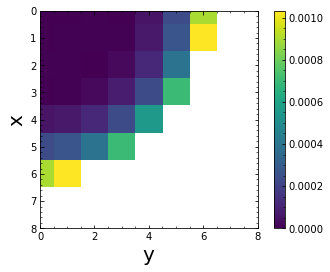

In [30]:
def h_analytic(x, y, h0, Rad) :
    '''
    Analytic h(r, t) as described in the document
    
    Parameters
    ----------
    r = radial distance away from middle of drop
    h0 = height at middle of drop
    Rad = radius of drop
    
    Returns
    h(r, t)
    '''
    xx, yy = np.meshgrid(x, y, indexing='ij')
    r = np.sqrt(xx**2 + yy**2)
    return np.sqrt( ((h0**2 + Rad**2)/(2*h0))**2 - r**2 ) - (Rad**2 - h0**2)/(2*h0)
xm = 0.002 #in m
ym = 0.002 #in m 
h0= 0.0005 #in m
x = np.linspace(0, 30*xm, 90)
y = x.copy()
h=h_gen(x, y, xm, ym, h0)
hana=h_analytic(x,y,h0,xm)
plt.imshow(abs(hana-h),origin='upper')
plt.xlim(0,3*xm//(x[1]-x[0]))
plt.ylim(3*ym//(y[1]-y[0]),0)
plt.ylabel('x')
plt.xlabel('y')
plt.colorbar()

### Test Case #2
The next important test case is to check that our Laplacian algorithm works as expected. Using the same approximations that we used to generate the spherical solution for $h(x,y,t)$ we can plug these into our Laplacian algorithm. On the output we would get $u(x,y,z)$. The paper describes the solution to the Laplacian using toroidal coordinates. Our solution should match this solution as best as it can on a coarse discrete grid. The solution we are attempting to match is 
$$u(\alpha,\beta)=u_s\sqrt{2(\cosh{\alpha}-\cos{\beta})}\int^\infty_0 d\tau\space P_{-\frac{1}{2}+i \tau}(\cosh{\alpha}) \frac{\cosh{(\theta_c \tau)}\cosh{(2\pi-\beta)\tau}}{\cosh{(\pi \tau)}\cosh{(\pi-\theta_c)\tau}}$$
where $\alpha$ and $\beta$ are toroidal coordinates, $\theta_c$ is the contact angle at which the surface of the sphere intersects the ground plane, $i$ is the imaginary number, and where we assume $\tau$ is the dummy variable for integration. And finally, $P_{-\frac{1}{2}+i \tau}$ is an Imaginary Legendre function of the first kind.

As it turns out, Imaginary Legendre function integrals are not well-known by Mathematica. By utilizing the sources provided in the document, we found a 60 year old mathematical physics textbook that contained an approximation to this solution. Their approximation assumed the source to be an infinitely thin spherical shell with equal angles of contact to the ground on all of its sides. We cannot replicate this derivation, but the correct answer is:
$$\phi=\frac{V}{2}\left[1+\sqrt{\left(\frac{\cosh{\alpha}-\cos{\beta}}{\cosh{\alpha}-\cos{(2\beta_0-\beta)}}\right)}\right]+\frac{V}{\pi}\left[\arctan{\frac{\sqrt{2}\cos{\left(\frac{\beta}{2}\right)}}{\sqrt{\cosh{\alpha}\cos{\beta}}}}-\sqrt{\frac{\cosh{\alpha}-\cos{\beta}}{\cosh{\alpha}-\cos{(2\beta_0-\beta)}}}\arctan{\frac{\sqrt{2}\cos{\frac{2\beta_0-\beta}{2}}}{\sqrt{\cosh{\alpha}-\cos{(2\beta_0-\beta)}}}}\right]$$
where $V$ is the maximum value at the ring, $\beta_0$ is the contact angle, and $\alpha$ and $\beta$ describe the toroidal coordinate system. In case you have never encountered the toroidal coordinate system before (like us), we will list the conversion to cartesian coordinates below:
$$x=a\frac{\sinh{\alpha}}{\cosh{\alpha}-\cos{\beta}}\cos{\psi}$$
$$y=a\frac{\sinh{\alpha}}{\cosh{\alpha}-\cos{\beta}}\sin{\psi}$$
$$z=a\frac{\sin{\beta}}{\cosh{\alpha}-\cos{\beta}}$$
where $\psi$ describes the angular coordinate. Since our problem was angularly symmetric we could ignore the $\psi$. 

In [31]:
def contact_angle(r, R, h) :
    '''
    Returns the contact angle of a circular drop
    
    Parameters
    ----------
    r = discretized radial coordinate
    R = radius of drop
    h = height distribution
    '''
    dr = r[1]-r[0]
    return np.pi - np.arctan2(1, h[int(R//dr)-1,0])

def spherical_test(xx,yy,zz,h0,R,u_s):
    '''
    Returns the 3d array of the spherical test case with the angle beta describing how it intersects the z=0 plane
    
    Parameters
    ----------
    x (1d array) = discretized x coordinate
    y (1d array) = discretized y coordinate
    z (1d array) = discretized z coordinate
    h0 (float) = height of h(0,0)
    R (float) = radius of drop
    u_s (float) = constant for the vapor density
    
    Outputs
    -------
    u (3d array) = test correct solution
    '''
    x,y,z=np.meshgrid(xx,yy,zz,indexing='ij')
    h=h_gen(xx, yy, R, R, h0)
    beta=contact_angle(xx, R,h)
    term1=np.cosh(np.log(np.sqrt((np.sqrt(x**2+y**2)+R)**2+z**2)/np.sqrt((np.sqrt(np.sqrt(x**2+y**2)-R)**2+z**2))))
    term2=(x**2+y**2+z**2-R**2)/np.sqrt((x**2+y**2+z**2+R**2)**2-4*(x**2+y**2)*R**2)
    left=u_s/2*(1+np.sqrt((term1-term2)/(term1-np.cos(2*beta-np.arccos(term2)))))
    right=u_s/np.pi*(np.arctan2(np.sqrt(2)*np.cos(np.arccos(term2)/2),np.sqrt(term1*term2))-np.sqrt((term1-term2)/(term1-np.cos(2*beta-np.arccos(term2))))*np.arctan2(np.sqrt(2)*np.cos(np.pi/2-np.arccos(term2)/2),np.sqrt(term1-np.cos(2*beta-np.arccos(term2)))))
    u=left+right
    return u

### Test Case #3
Another test case we can implement is if we took the derivatives correctly from $u$ to get $J$. Asymptotically, in the spherical limit it would be expected that $J$ evaluated on the surface of the spherical droplet would have the following form
$$ J_s(r,t)=A\left(1-\left(\frac{r}{R}\right)^2\right)^{-\lambda}$$
where $\lambda\equiv\frac{\pi-2\theta_c}{2\pi-2\theta_c}$ and $A$ is some constant. We can check this by either fitting our solution and solving for the constant value of A, or dividing it by the expected solution and see if we get a roughly constant output after the division.
We never got to this test case since we skipped the use of $J_s$ by our use of integration by parts above. However, our use of test case 2 should be sufficient as these both test the exact same behavior.

# Testing Functions
This first test we will be doing 1 iteration in our spherical limit case where x is equivalent to y. We will be doing this so far away, we are practically at infinity (0.06m). We want to know how good our algorithm is in the short range.

In [18]:
#Spherical Case with data saved into long.npy files
xm = 0.002 #in m 
ym = 0.002 #in m 
#Infinity is approximately 0.06
u_s = 4.85 # in g/m^3
upgrids=1
rho = 1
divide=1000
tol=1e-5
maxiter=20000
tmax = 0.1
t = np.linspace(0, tmax, 200)
h0= 0.0005 #in m

x = np.linspace(0, 30*xm, 90)
y = x.copy()
z = np.linspace(0, 120*h0, 720)
h=h_gen(x, y, xm, ym, h0)
ug = good_guess(x,y,z,u_s,h,xm,ym)
x,y,z,h,u=multigrid(upgrids,x,y,z,h, u_s,ug,xm,ym,h0, maxiter, tol,divide,True)

Reached  0  iterations
Reached  1000  iterations
Reached  2000  iterations
Reached  3000  iterations
Reached  4000  iterations
Reached  5000  iterations
Reached  6000  iterations
Reached  7000  iterations
Reached  8000  iterations
Reached  9000  iterations
Reached  10000  iterations
Reached  11000  iterations
Reached  12000  iterations
Reached  13000  iterations
Reached  14000  iterations
Reached  15000  iterations
Reached  16000  iterations
Reached  17000  iterations
Reached  18000  iterations
Reached  19000  iterations
We done! Reached tolerance  9.999919721911018e-06  after  19828  iterations


In [ ]:
uanalytic=spherical_test(x,y,z,h0,xm,u_s)

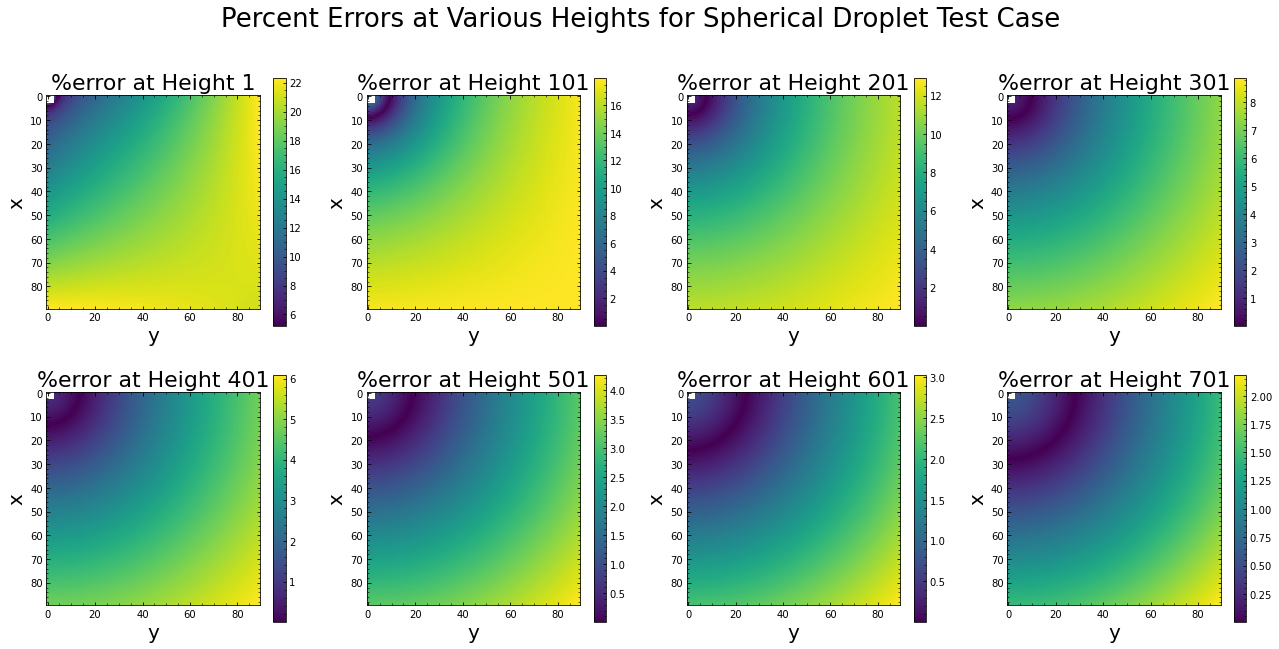

In [63]:
height=1
plt.figure(figsize=(22,10))
plt.suptitle('Percent Errors at Various Heights for Spherical Droplet Test Case')
plt.subplot(241)
plt.imshow(100*abs(1-u[:,:,height]/uanalytic[:,:,height]))
plt.title(f'%error at Height {height}')
plt.ylabel('x')
plt.xlabel('y')
plt.colorbar()
height=101
plt.subplot(242)
plt.imshow(100*abs(1-u[:,:,height]/uanalytic[:,:,height]))
plt.title(f'%error at Height {height}')
plt.ylabel('x')
plt.xlabel('y')
plt.colorbar()
height=201
plt.subplot(243)
plt.imshow(100*abs(1-u[:,:,height]/uanalytic[:,:,height]))
plt.title(f'%error at Height {height}')
plt.ylabel('x')
plt.xlabel('y')
plt.colorbar()
height=301
plt.subplot(244)
plt.imshow(100*abs(1-u[:,:,height]/uanalytic[:,:,height]))
plt.title(f'%error at Height {height}')
plt.ylabel('x')
plt.xlabel('y')
plt.colorbar()
height=401
plt.subplot(245)
plt.imshow(100*abs(1-u[:,:,height]/uanalytic[:,:,height]))
plt.title(f'%error at Height {height}')
plt.ylabel('x')
plt.xlabel('y')
plt.colorbar()
height=501
plt.subplot(246)
plt.imshow(100*abs(1-u[:,:,height]/uanalytic[:,:,height]))
plt.title(f'%error at Height {height}')
plt.ylabel('x')
plt.xlabel('y')
plt.colorbar()
height=601
plt.subplot(247)
plt.imshow(100*abs(1-u[:,:,height]/uanalytic[:,:,height]))
plt.title(f'%error at Height {height}')
plt.ylabel('x')
plt.xlabel('y')
plt.colorbar()
height=701
plt.subplot(248)
plt.imshow(100*abs(1-u[:,:,height]/uanalytic[:,:,height]))
plt.title(f'%error at Height {height}')
plt.ylabel('x')
plt.xlabel('y')
plt.colorbar()

The next test will be doing is the exact same approximation, but for our spherical droplet, but much closer to the center where we are interested. Thus we are going to only 0.02 m.

In [16]:
#Spherical Case with our assumption of pushing in infinity
xm = 0.002 #in m 
ym = 0.002 #in m 
#Infinity is approximately 0.02
u_s = 4.85 # in g/m^3
upgrids=4
rho = 1
divide=1000
tol=1e-5
maxiter=20000
tmax = 0.1
t = np.linspace(0, 2*tmax/200, 2)
h0= 0.0005 #in m
x = np.linspace(0, 10*xm, 40)
y = x.copy()
z = np.linspace(0, 40*h0, 160)
uanalytic=spherical_test(x,y,z,h0,xm,u_s)
u_s = 4.85-uanalytic[-1,1,-1]

h=h_gen(x, y, xm, ym, h0)
ug = good_guess(x,y,z,u_s,h,xm,ym)
x,y,z,h,u=multigrid(upgrids,x,y,z,h, u_s,ug,xm,ym,h0, maxiter, tol,divide,True)

<ipython-input-15-661dfc18f9eb>:91: RuntimeWarning: invalid value encountered in sqrt
  term1=np.cosh(np.log(np.sqrt((np.sqrt(x**2+y**2)+R)**2+z**2)/np.sqrt((np.sqrt(np.sqrt(x**2+y**2)-R)**2+z**2))))
<ipython-input-15-661dfc18f9eb>:93: RuntimeWarning: invalid value encountered in arccos
  left=u_s/2*(1+np.sqrt((term1-term2)/(term1-np.cos(2*beta-np.arccos(term2)))))
<ipython-input-15-661dfc18f9eb>:94: RuntimeWarning: invalid value encountered in arccos
  right=u_s/np.pi*(np.arctan2(np.sqrt(2)*np.cos(np.arccos(term2)/2),np.sqrt(term1*term2))-np.sqrt((term1-term2)/(term1-np.cos(2*beta-np.arccos(term2))))*np.arctan2(np.sqrt(2)*np.cos(np.pi/2-np.arccos(term2)/2),np.sqrt(term1-np.cos(2*beta-np.arccos(term2)))))


Reached  0  iterations
Reached  1000  iterations
Reached  2000  iterations
Reached  3000  iterations
Reached  4000  iterations
We done! Reached tolerance  9.999670078586487e-06  after  4618  iterations
Now starting stretch  1
Reached  0  iterations
We done! Reached tolerance  9.999950551629425e-06  after  81  iterations
Now starting stretch  2
Reached  0  iterations
We done! Reached tolerance  9.971202265101481e-06  after  38  iterations
Now starting stretch  3
Reached  0  iterations
We done! Reached tolerance  9.075129962658282e-06  after  16  iterations


In [17]:
u=u+uanalytic[-1,1,-1]

In [17]:
uanalytic=spherical_test(x,y,z,h0,xm,4.85)
height=1
plt.figure(figsize=(22,10))
plt.suptitle('Percent Errors at Various Heights for Spherical Droplet Test Case')
plt.subplot(241)
plt.imshow(100*abs(1-u[:,:,height]/uanalytic[:,:,height]))
plt.title(f'%error at Height {height}')
plt.ylabel('x')
plt.xlabel('y')
plt.colorbar()
height=161
plt.subplot(242)
plt.imshow(100*abs(1-u[:,:,height]/uanalytic[:,:,height]))
plt.title(f'%error at Height {height}')
plt.ylabel('x')
plt.xlabel('y')
plt.colorbar()
height=321
plt.subplot(243)
plt.imshow(100*abs(1-u[:,:,height]/uanalytic[:,:,height]))
plt.title(f'%error at Height {height}')
plt.ylabel('x')
plt.xlabel('y')
plt.colorbar()
height=481
plt.subplot(244)
plt.imshow(100*abs(1-u[:,:,height]/uanalytic[:,:,height]))
plt.title(f'%error at Height {height}')
plt.ylabel('x')
plt.xlabel('y')
plt.colorbar()
height=641
plt.subplot(245)
plt.imshow(100*abs(1-u[:,:,height]/uanalytic[:,:,height]))
plt.title(f'%error at Height {height}')
plt.ylabel('x')
plt.xlabel('y')
plt.colorbar()
height=801
plt.subplot(246)
plt.imshow(100*abs(1-u[:,:,height]/uanalytic[:,:,height]))
plt.title(f'%error at Height {height}')
plt.ylabel('x')
plt.xlabel('y')
plt.colorbar()
height=961
plt.subplot(247)
plt.imshow(100*abs(1-u[:,:,height]/uanalytic[:,:,height]))
plt.title(f'%error at Height {height}')
plt.ylabel('x')
plt.xlabel('y')
plt.colorbar()
height=1021
plt.subplot(248)
plt.imshow(100*abs(1-u[:,:,height]/uanalytic[:,:,height]))
plt.title(f'%error at Height {height}')
plt.ylabel('x')
plt.xlabel('y')
plt.colorbar()

![image.png](SphericalDropletCase.png)

Now we will be applying the exact same algorithm as used above to the elliptical case. Our infinity is again 0.02m.

In [70]:
#Ellipsoidal Case with data
xm = 0.002 #in m 
ym = 0.001 #in m 
u_s = 4.85 # in g/m^3
upgrids=1
rho = 1
divide=1000
tol=1e-5
maxiter=20000
tmax = 0.1
t = np.linspace(0, 49*tmax/200, 49)
h0= 0.0005 #in m
uanalytic=spherical_test(x,y,z,h0,xm,u_s)
u_s = 4.85-uanalytic[-1,1,-1]

x = np.linspace(0, 30*xm, 90)
y = x.copy()
z = np.linspace(0, 120*h0, 720)
h=h_gen(x, y, xm, ym, h0)
ug = good_guess(x,y,z,u_s,h,xm,ym)
x,y,z,h,u1=multigrid(upgrids,x,y,z,h, u_s,ug,xm,ym,h0, maxiter, tol,divide,True)

Reached  0  iterations
Reached  1000  iterations
Reached  2000  iterations
Reached  3000  iterations
Reached  4000  iterations
Reached  5000  iterations
Reached  6000  iterations
Reached  7000  iterations
Reached  8000  iterations
Reached  9000  iterations
Reached  10000  iterations
Reached  11000  iterations
Reached  12000  iterations
Reached  13000  iterations
Reached  14000  iterations
Reached  15000  iterations
Reached  16000  iterations
Reached  17000  iterations
Reached  18000  iterations
We done! Reached tolerance  9.999932238195322e-06  after  18089  iterations


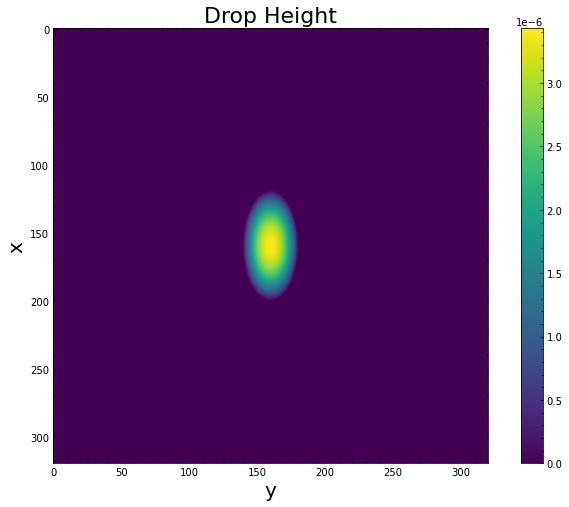

In [34]:
#print(zloaded)
plot_drop(h_gen(x, y, xm, ym, h0news[48]), size=(12, 8))

# Final animations
Since these cells took so long to run, we saves our data in external files so we would not have to rerun them. This is our results we gathered after a 5 hour running session.

In [2]:
#np.save('h0newsellipse.npy',h0news)

In [22]:
xm = 0.002
ym = 0.002

x = np.load('xlong.npy')
dx = x[1]-x[0]
print(f'x: {x.shape}')

y = np.load('ylong.npy')
dy = y[1]-y[0]
print(f'y: {y.shape}')

z = np.load('zlong.npy')
dz = z[1]-z[0]
print(f'z: {z.shape}')

ul = np.load('ulong.npy')
print(f'u: {ul.shape}')

h0t = np.load('h0newslong.npy')
print(f'h(t): {h0t.shape}')

x: (160,)
y: (160,)
z: (160,)
u: (160, 160, 160)
h(t): (46,)


In [23]:
xp = np.concatenate((-x[::-1], x))
yp = np.concatenate((-y[::-1], y))

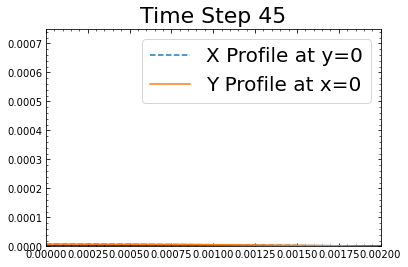

In [24]:
N = len(h0t)
framefactor = 1

# h0t should be an array of h0 values at different times
fig, ax = plt.subplots()
ax.set_xlim(0, max(xm, ym))
ax.set_ylim(0, 1.5*np.max(h0t))
ax.axhline(0, c='k')

TRUEx, = ax.plot(x, h_gen(x, y, xm, ym, h0t[0])[:,0], label='X Profile at y=0', ls='--')
TRUEy, = ax.plot(y, h_gen(x, y, xm, ym, h0t[0])[0,:], label='Y Profile at x=0')

ax.legend()

def animate(n) :
    TRUEx.set_data(x, h_gen(x, y, xm, ym, h0t[n])[:,0])
    TRUEy.set_data(y, h_gen(x, y, xm, ym, h0t[n])[0,:])
    
    ax.set_title(f'Time Step {framefactor*n}')
    return (TRUEx, TRUEy)

anim = animation.FuncAnimation(fig, animate, frames = N//framefactor, interval = N, repeat = False, blit = True)
anim

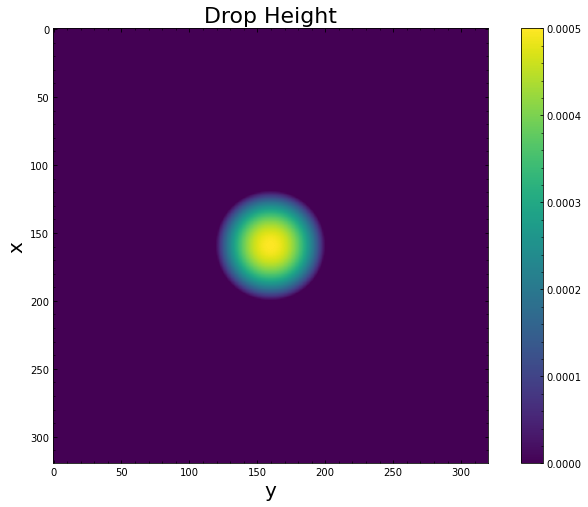

In [26]:
h_gen(x, y, xm, ym, h0t[0])
plot_drop(h_gen(x, y, xm, ym, h0t[0]))


Here is the exact same thing except for our elliptical droplet.

x: (160,)
y: (160,)
z: (160,)
u: (160, 160, 160)
h(t): (49,)


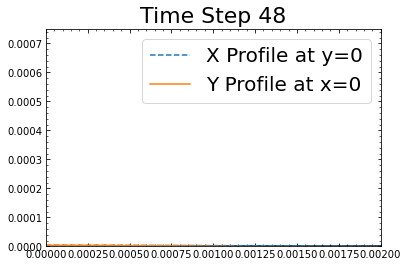

In [28]:
xm = 0.002
ym = 0.001

x = np.load('xellipse.npy')
dx = x[1]-x[0]
print(f'x: {x.shape}')

y = np.load('yellipse.npy')
dy = y[1]-y[0]
print(f'y: {y.shape}')

z = np.load('zellipse.npy')
dz = z[1]-z[0]
print(f'z: {z.shape}')

ul = np.load('uellipse.npy')
print(f'u: {ul.shape}')

h0t = np.load('h0newsellipse.npy')
print(f'h(t): {h0t.shape}')
xp = np.concatenate((-x[::-1], x))
yp = np.concatenate((-y[::-1], y))
N = len(h0t)
framefactor = 1

# h0t should be an array of h0 values at different times
fig, ax = plt.subplots()
ax.set_xlim(0, max(xm, ym))
ax.set_ylim(0, 1.5*np.max(h0t))
ax.axhline(0, c='k')

TRUEx, = ax.plot(x, h_gen(x, y, xm, ym, h0t[0])[:,0], label='X Profile at y=0', ls='--')
TRUEy, = ax.plot(y, h_gen(x, y, xm, ym, h0t[0])[0,:], label='Y Profile at x=0')

ax.legend()

def animate(n) :
    TRUEx.set_data(x, h_gen(x, y, xm, ym, h0t[n])[:,0])
    TRUEy.set_data(y, h_gen(x, y, xm, ym, h0t[n])[0,:])
    
    ax.set_title(f'Time Step {framefactor*n}')
    return (TRUEx, TRUEy)

anim = animation.FuncAnimation(fig, animate, frames = N//framefactor, interval = N, repeat = False, blit = True)
anim

## Conclusion
Things to be worked on in the future on this research project:
1. Implementing $v$ into the algorithm efficiently to not slow it down more than it already is.
2. Making the Laplacian even more efficient than it already is since it is still quite slow.
3. Devising a better algorithm for calculating the final IVP with better errors than the Euler method, but is efficient to not slow the Laplacian too much down.
4. Utilizing a grid of CPUs or graphics cards to take advantage of the jit parallel processes to speed up computations.
5. Coding up adaptive quadrature to speed up the Laplacian.

The END!